In [1]:
from runner import test_run, TestPlan, TestStep
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
# 1. Create a test plan consisting of steps.
step_duration_ms = 5_000
step_range = [0,0]

steps = [
    TestStep(bottom_throttle=i, top_throttle=i, duration_ms=step_duration_ms)
    for i in step_range
]
plan = TestPlan("test", steps=steps)

plan

TestPlan(name='test', steps=[TestStep(duration_ms=5000, top_throttle=0, bottom_throttle=0, pitch_angle=None, roll_angle=None), TestStep(duration_ms=5000, top_throttle=0, bottom_throttle=0, pitch_angle=None, roll_angle=None)])

In [16]:
test_directory = Path("../test_data/load_cell_calibration_data/")

In [86]:
data_dict = {}
data_dict["test_load_cell_offset_recal"] = test_run(
    filename=test_directory / "test_load_cell_offset_recal.csv", plan=plan
)
data_dict["test_load_cell_200g_alum_0"] = test_run(
    filename=test_directory / "test_load_cell_200g_alum_duct_0.csv", plan=plan
)
data_dict["test_load_cell_200g_alum_1"] = test_run(
    filename=test_directory / "test_load_cell_200g_alum_duct_1.csv", plan=plan
)
data_dict["test_load_cell_1kg_alum_0"] = test_run(
    filename=test_directory / "test_load_cell_1kg_alum_duct_0.csv", plan=plan
)
data_dict["test_load_cell_1kg_alum_1"] = test_run(
    filename=test_directory / "test_load_cell_1kg_alum_duct_1.csv", plan=plan
)
data_dict["test_load_cell_2kg_alum_0"] = test_run(
    filename=test_directory / "test_load_cell_2kg_alum_duct_0.csv", plan=plan
)
data_dict["test_load_cell_2kg_alum_1"] = test_run(
    filename=test_directory / "test_load_cell_2kg_alum_duct_1.csv", plan=plan
)

Loading saved data
Loading saved data
Tx: Begin new test spec
FAIL Rx: 
Tx: time_ms,top_throttle,bottom_throttle,pitch_us,roll_us
FAIL Rx: 
FAIL Rx: 
Arming...
FAIL Rx: 
Running test...
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: 
Skipped rx
Rx: Starting test

Skipped rx
Rx: time_us,top_rpm,bot_rpm,v_bat,i_bat,i_top,i_bot,thrust_N,torque_Nm

Skipped rx
Rx: 314,0,0,2.688000,10.240000,0.189020,-0.166920,3.655787,0.000000

Rx: 4170,0,0,2.688000,10.240000,0.130860,-0.208650,3.655787,0.000000

Rx: 8180,0,0,2.688000,10.240000,0.087240,-0.180830,3.655787,-0.000003

Rx: 12166,0,0,2.688000,10.240000,0.247180,-0.194740,3.655787,-0.000003

Rx: 16176,0,0,2.688000,10.240000,0.159940,-0.111280,3.655787,-0.000003

Rx: 20166,0,0,2.688000,10.240000,0.145400,-0.125190,3.655787,0.000000

Rx: 

In [87]:
# Aggregate test data
df_all = pd.concat(data_dict, names=["test_name"])
df_all.loc['test_load_cell_offset_recal']

,top_motor_rpm,bottom_motor_rpm,batt_voltage_V,batt_current_A,top_current_A,bottom_current_A,thrust_N,torque_N
time_ms,,,,,,,,
0.451,0.0,0.0,2.688,10.24,36.582642,34.747181,0.000656,0.0
5.174,0.0,0.0,2.688,10.24,36.582642,34.747181,0.000656,0.0
9.157,0.0,0.0,2.688,10.24,36.582642,34.747181,0.000656,0.0
13.157,0.0,0.0,2.688,10.24,36.582642,34.747181,0.000656,0.0
17.157,0.0,0.0,2.688,10.24,36.582642,34.747181,0.000656,0.0
...,...,...,...,...,...,...,...,...
4986.157,0.0,0.0,2.688,10.24,36.582642,34.747181,-0.000437,0.0
4990.157,0.0,0.0,2.688,10.24,36.582642,34.747181,-0.000437,0.0
4994.157,0.0,0.0,2.688,10.24,36.582642,34.747181,-0.000437,0.0


In [88]:
# Generate buckets for averaging based on step duration defined in testing
stable_step_duration_ms = step_duration_ms / 2
transient_offset_ms = (
    500  # Ignore first 500 ms of each throttle step to allow transients to settle
)
step_start_times = np.arange(len(step_range)) * step_duration_ms


# Aggregate data for each throttle step
df_steps = (
    pd.concat(
        [
            df_all.loc[
                (
                    slice(None),
                    slice(
                        t_start + transient_offset_ms,
                        t_start + transient_offset_ms + stable_step_duration_ms,
                    ),
                ),
                :,
            ]
            for t_start in step_start_times
        ],
        keys=step_range,
        names=["throttle"],
    )
    .groupby(["test_name", "throttle"])
    .agg(["mean", "std"])
    .sort_values(by=('thrust_N', 'mean'))
)

df_steps

top_motor_rpm      bottom_motor_rpm       \
                                              mean  std             mean  std   
test_name                   throttle                                            
test_load_cell_offset_recal 0                  0.0  0.0              0.0  0.0   
test_load_cell_200g_alum_0  0                  0.0  0.0              0.0  0.0   
test_load_cell_200g_alum_1  0                  0.0  0.0              0.0  0.0   
test_load_cell_1kg_alum_0   0                  0.0  0.0              0.0  0.0   
test_load_cell_1kg_alum_1   0                  0.0  0.0              0.0  0.0   
test_load_cell_2kg_alum_0   0                  0.0  0.0              0.0  0.0   
test_load_cell_2kg_alum_1   0                  0.0  0.0              0.0  0.0   

                                     batt_voltage_V      batt_current_A       \
                                               mean  std           mean  std   
test_name                   throttle                                           
test_load_cell_offset_recal 0                 2.688  0.0          10.24  0.0   
test_load_cell_200g_alum_0  0                 2.688  0.0          10.24  0.0   
test_load_cell_200g_alum_1  0                 2.688  0.0          10.24  0.0   
test_load_cell_1kg_alum_0   0                 2.688  0.0          10.24  0.0   
test_load_cell_1kg_alum_1   0                 2.688  0.0          10.24  0.0   
test_load_cell_2kg_alum_0   0                 2.688  0.0          10.24  0.0   
test_load_cell_2kg_alum_1   0                 2.688  0.0          10.24  0.0   

                                     top_current_A           bottom_current_A  \
                                              mean       std             mean   
test_name                   throttle                                            
test_load_cell_offset_recal 0            36.582642  0.000000        34.747181   
test_load_cell_200g_alum_0  0             0.172991  0.057361        -0.192470   
test_load_cell_200g_alum_1  0             0.170665  0.055308        -0.185303   
test_load_cell_1kg_alum_0   0             0.163243  0.054979        -0.198835   
test_load_cell_1kg_alum_1   0             0.162383  0.060628        -0.193115   
test_load_cell_2kg_alum_0   0             0.166780  0.060096        -0.196610   
test_load_cell_2kg_alum_1   0             0.163709  0.058143        -0.190178   

                                                 thrust_N            torque_N  \
                                           std       mean       std      mean   
test_name                   throttle                                            
test_load_cell_offset_recal 0         0.000000  -0.000838  0.002075  0.000000   
test_load_cell_200g_alum_0  0         0.049791   2.585673  0.008002  0.043140   
test_load_cell_200g_alum_1  0         0.052053   3.676383  0.008175  0.000147   
test_load_cell_1kg_alum_0   0         0.048856  10.269110  0.044683  0.044682   
test_load_cell_1kg_alum_1   0         0.048693  10.677989  0.020533  0.069345   
test_load_cell_2kg_alum_0   0         0.050983  20.466348  0.005257 -0.000001   
test_load_cell_2kg_alum_1   0         0.050190  21.359356  0.013334 -0.000002   

                                                
                                           std  
test_name                   throttle            
test_load_cell_offset_recal 0         0.000000  
test_load_cell_200g_alum_0  0         0.887067  
test_load_cell_200g_alum_1  0         0.003491  
test_load_cell_1kg_alum_0   0         0.727614  
test_load_cell_1kg_alum_1   0         1.122900  
test_load_cell_2kg_alum_0   0         0.000008  
test_load_cell_2kg_alum_1   0         0.000013

In [89]:
hx711_scale_factor = 21400
load_cell_offset_N = df_steps.loc['test_load_cell_offset_recal']['thrust_N']['mean'][0]
load_cell_offset_bin = int(load_cell_offset_N * hx711_scale_factor)

# Remove offset test from df and subtract offset from existing measurements
df_steps_nonzero = df_steps.drop('test_load_cell_offset_recal')
thrust_calibration_series = df_steps_nonzero['thrust_N']['mean'] - load_cell_offset_N

C:\Users\matth\AppData\Local\Temp\ipykernel_30432\2388834874.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_steps_nonzero = df_steps.drop('test_load_cell_offset_recal')


In [94]:
mass_true_kg = np.array([0.200, 0.200, 1.0, 1.0, 2.0, 2.0])
thrust_true_N = 9.81 * mass_true_kg

In [95]:
def calibrated_thrust_N(measured_thrust, gain, offset):
    return gain * measured_thrust + offset

In [96]:
from scipy.optimize import curve_fit

In [101]:
thrust_fit_popt,thrust_fit_pcov = curve_fit(calibrated_thrust_N, thrust_calibration_series, thrust_true_N, sigma=df_steps_nonzero['thrust_N']['std'], absolute_sigma=True)
thrust_cal_fcn = np.vectorize(lambda T: calibrated_thrust_N(T, thrust_fit_popt[0], thrust_fit_popt[1]))
thrust_line_pts = [0,25]

print(thrust_fit_popt)

[ 1.00812612 -1.14492994]


In [102]:
new_load_cell_gain = 21400 / 1.17
np.round(new_load_cell_gain)

18291.0

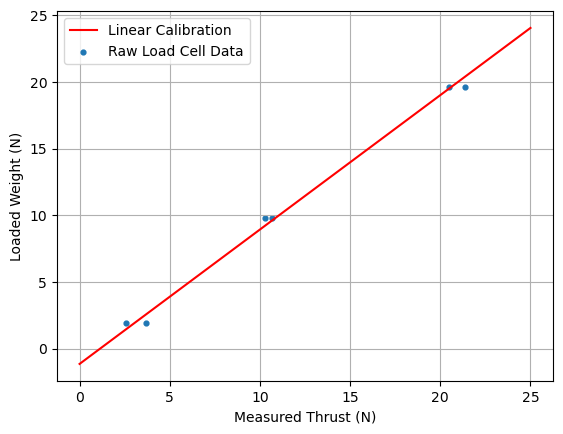

In [99]:
plt.plot(thrust_line_pts, thrust_cal_fcn(thrust_line_pts), color='r', label='Linear Calibration')
plt.scatter(thrust_calibration_series, thrust_true_N, label='Raw Load Cell Data', s=12)
plt.ylabel('Loaded Weight (N)')
plt.xlabel('Measured Thrust (N)')
plt.legend()
plt.grid()